In [10]:
import emcee
import time
import math
import corner
import glob
import pandas as pd
import numpy as np
import scipy.optimize as op
import astropy.io.ascii as asci
from astropy.io import fits
from astropy.table import Table
from collections import Counter
from multiprocessing import Queue, Process, Pool
import time

%matplotlib notebook
import matplotlib.pyplot as plt


In [2]:
from multiprocessing import cpu_count
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

8 CPUs


## Read in the data

Force-fit photometry, as well as the "x" and "y" data needed to estimate the flux in individual epochs has been stored in individual fits files.

In [3]:
targets = glob.glob('ZTF18*/')

In [4]:
name1 = targets[0][:-1]
name2 = targets[1][:-1]
print ('%s: we should have a very good light curve for this one; \n%s: close to center of galaxy, bad subtraction'%(name1, name2))

ZTF18aaxsioa: we should have a very good light curve for this one; 
ZTF18aayjomr: close to center of galaxy, bad subtraction


In [5]:
forcepath1 = glob.glob(name1+'/force*.fits')[0]
xypath1 = glob.glob(name1+'/xy*.fits')[0]
forcepath2 = glob.glob(name2+'/force*.fits')[0]
xypath2 = glob.glob(name2+'/xy*.fits')[0]

In [6]:
forcetb1 = Table(fits.open(forcepath1)[1].data).to_pandas()
forcetb1 = forcetb1[forcetb1['rvalue']!=0]
tb1 = Table(fits.open(xypath1)[1].data).to_pandas()

forcetb2 = Table(fits.open(forcepath2)[1].data).to_pandas()
forcetb2 = forcetb2[forcetb2['rvalue']!=0]
tb2 = Table(fits.open(xypath2)[1].data).to_pandas()

In [611]:
# reset data for new files
info_path = "../../early_Ia/2018/info/"
xy_path = "../../early_Ia/2018/xydata/"

info_files = glob.glob(info_path + "force_phot_ZTF*fits")
xy_files = glob.glob(xy_path + "xydata_ZTF*fits")

ztf_name = 'ZTF18aaxsioa'
info_file = info_path + 'force_phot_{}_info_refcut.fits'.format(ztf_name)
xy_file = xy_path + 'xydata_{}_refcut.fits'.format(ztf_name)

info_tbl = Table.read(info_file)
xy_tbl = Table.read(xy_file)
info_df = info_tbl.to_pandas()
xy_df = xy_tbl.to_pandas()

tb1=xy_df.copy()

## Define posterior calculation

We attempt two different models to measure the slope: a mixture model (see [Hogg, Bovy, and Lang 2010](https://arxiv.org/abs/1008.4686)) that treats the data as coming from a foreground population (the actual flux measured by the PSF) and a noisy high-variance background population. While, in principle, this is the most appropriate model to deal with bad pixels or columns in the subtraction image, in practice, during epochs when the SN (or other transient) is not clearly detected there isn't enough signal for the foreground linear signal to constrain the flux. By definition the slope = 0 when the source isn't detected, which is why the mixture model fails to converge. (TODO: try adjusting the prior so that most points must belong to the foreground population)

The second model is just a linear model $y = mx + b$, where we assume the uncertainties are underestimated by a constant factor $\sigma_0$. This yields a likelihood: 

$$ \ln \mathcal{L} = \sum_i \ln \left(\frac{1}{\sqrt{2\pi (\sigma_i^2 + \sigma_0^2)}}\right) - 
                               \frac{(y_i - (mx_i + b))^2}{2(\sigma_i^2 + \sigma_0^2)}$$
                               
For this likelihood we can marginalize over $b$ and $\sigma_0$ in order to estimate the slope, $m$ and it's uncertainty, from which the SN flux can be trivially estimated.

In [540]:
# likelihood function lnL
def mixture_lnlike(theta, x, y, sigma_y):
    m, b, lnp_b, lnv_b, y_b = theta
    model = m * x + b
    bad_noise = np.exp(lnv_b) + sigma_y*sigma_y
    ln_l = np.sum( np.log( (1 - np.exp(lnp_b))/np.sqrt(2*np.pi*sigma_y*sigma_y)*np.exp(-1/2*((y - model)/sigma_y)**2) + 
                    (np.exp(lnp_b))/np.sqrt(2*np.pi*(bad_noise))*np.exp(-1/2*(y - y_b)**2/(bad_noise))
                          )
                  )
    
    return ln_l

def systematic_lnlike(theta, x, y, sigma_y):
    m, b, lnsig_0 = theta
    model = m * x + b
    sig_0 = np.exp(lnsig_0)

    chi2_term = -1/2*np.sum((y - model)**2/(sigma_y**2 + sig_0**2))
    error_term = np.sum(np.log(1/np.sqrt(2*np.pi*(sigma_y**2 + sig_0**2))))
    ln_l = chi2_term + error_term

    return ln_l

def mixture_lnprior(theta):
    m, b, lnp_b, lnv_b, y_b = theta
    if (-1e6 < m < 1e6 and -1e6 < b < 1e6 and 
        np.log(1e-3) < lnp_b < np.log(0.75) and 
        -50 < lnv_b < 50 and -1e4 < y_b < 1e4):
        return 0.0
    return -np.inf

systematic_nll = lambda *args: -systematic_lnlike(*args)
mixture_nll = lambda *args: -mixture_lnlike(*args)

def systematic_lnprior(theta):
    m, b, lnsig_0 = theta
    if (-1e6 < m < 1e6 and -1e6 < b < 1e6 and 
        -50 < lnsig_0 < 50):
        return 0.0
    return -np.inf

# The full log-probability function is
def mixture_lnprob(theta, x, y, yerr):
    lp = mixture_lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + mixture_lnlike(theta, x, y, yerr)

def systematic_lnprob(theta, x, y, yerr):
    lp = systematic_lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + systematic_lnlike(theta, x, y, yerr)

### An example MCMC calculation

Below we show example results for a subtraction where a maximum-likelihood approach would produce unreasonable estimates of the flux.

In [14]:
nsteps = 5000
ndim, nwalkers = 3, 250
f_true = 1
nburn = 2500

A note on selecting individual epochs for testing the single runs described below:

|source|systematic|mixture|winner|description|
|-----:|:---------|:-----:|:----:|:--------------------------------------------------:|
|0   |-21.2367 +/- 45.9104|-20.6102 +/- 46.9133| **identical results** | mixture model does not converge|
|1   |11.3274 +/- 37.7320|11.4301 +/- 39.1333| **identical results** | mixture model takes long time to converge|
|3   |-39.2906 +/- 28.6022|-40.8055 +/- 30.7562| **nearly identical results**| mixture model takes long time to converge|
|45  |144.4199 +/- 403.7593|   -59.7052 +/- 185.3048  | **mixture better** | non-detection with several significant outliers|
|50  |18.7046 +/- 41.9355|18.7961 +/- 41.8645| **identical results** | non-detection with no discernable outliers|
|180 |-328.9045 +/- 184.8424|-383.1907 +/- 387.9986| **systematic better** | non-detection that is noisy but no obvious outliers|
|219 |1602.1114 +/- 41.2490|1601.9268 +/- 41.0655| **identical results** | detection with few (if any) outliers|
|309 |4920.5827 +/- 125.3719|6169.7216 +/- 85.0924| **very different, no idea which is better** | detection with (minor?) outliers|
|355 |2665.4614 +/- 112.5566|3022.7160 +/- 97.3201| **different, mixture probably better**| low flux |
|356 |2751.9638 +/- 79.5913|2761.8174 +/- 76.9250|**identical results** | low flux |
|357 |2727.6972 +/- 65.2021|2727.3035 +/- 65.4926| **identical results** | low flux |
|384 |1857.0322 +/- 34.4734|1855.2814 +/- 34.5987| **identical results** | low DN |
|385 |1091.7923 +/- 41.5043|1091.6334 +/- 41.2160| **identical results** | low DN |
|395 |642.1236 +/- 21.5581|642.1264 +/- 21.5667| **identical results** | lots of scatter in brighter obs |
|407 |1424.4131 +/- 30.2792|1424.7190 +/- 30.4118| **identical results** |not a line/lots of scatter|
|504 |193.7652 +/- 39.9088|194.2869 +/- 40.6848| **identical results** |flat, but for 1 point|
|519 |389.3833 +/- 43.3396|389.2986 +/- 43.2323| **identical results** | not particularly linear|

<IPython.core.display.Javascript object>


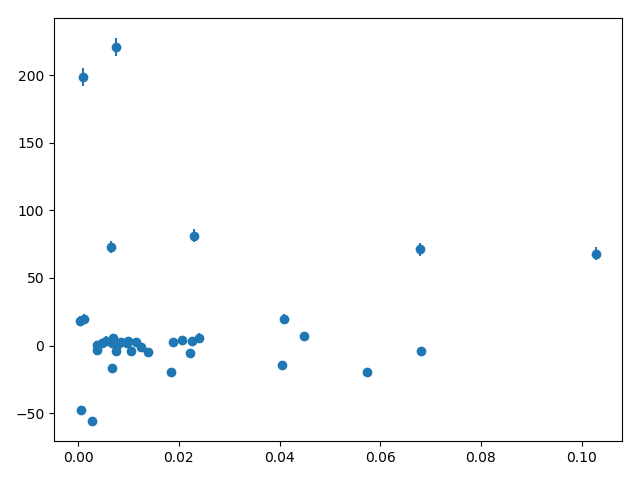

In [612]:
# for i in range(380,400):
#     subtb = tb1[tb1['index']==i]
#     x = subtb['x'].values
#     y = subtb['y'].values
#     yerr = subtb['ey'].values

#     fig, ax = plt.subplots()
#     ax.errorbar(x, y, yerr, fmt='o')
#     #     ax.set_xlim(0,0.03)
#     fig.tight_layout()

subtb = tb1[tb1['index']==45]
x = subtb['x'].values
y = subtb['y'].values
yerr = subtb['ey'].values

fig, ax = plt.subplots()
ax.errorbar(x, y, yerr, fmt='o')
#     ax.set_xlim(0,0.03)
fig.tight_layout()

### Test the systematic uncertainties likelihood

In [613]:
result = op.minimize(systematic_nll, [2, 0, 2], 
                     method='Powell', args=(x, y, yerr))
ml_guess = result["x"]
print(ml_guess)

[150.12719071  13.53147761   3.97578448]


In [614]:
if ml_guess[-1] < -49:
    ml_guess[-1] = -35
ndim = len(ml_guess)
nwalkers = 250

pos = [ml_guess + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

# set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, systematic_lnprob, 
                                args=(x, y, yerr))

max_samples = 15000

index = 0
autocorr = np.empty(max_samples)
old_tau = np.inf
check_tau = 250
for sample in sampler.sample(pos, iterations=max_samples, progress=True):
    if sampler.iteration % check_tau:
        continue
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

 27%|██▋       | 4000/15000 [00:42<01:57, 93.43it/s] 


<IPython.core.display.Javascript object>


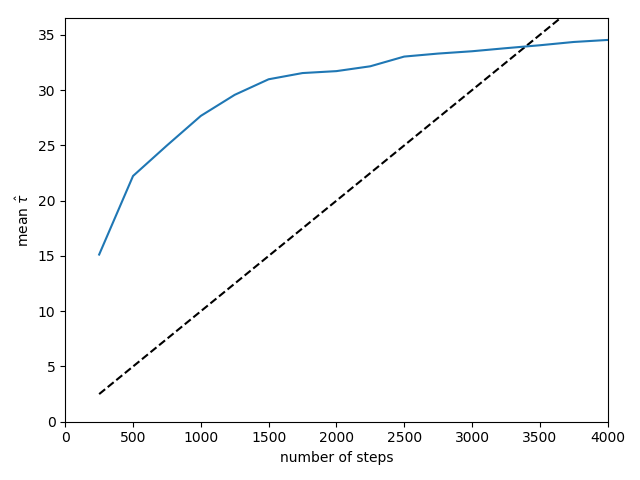

In [615]:
n = check_tau*np.arange(1, index+1)
mean_tau = autocorr[:index]
plt.figure()
plt.plot(n, n / 100.0, "--k")
plt.plot(n, mean_tau)
plt.xlim(0, n.max())
plt.ylim(0, mean_tau.max() + 0.1*(mean_tau.max() - mean_tau.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$")
plt.tight_layout()

<IPython.core.display.Javascript object>


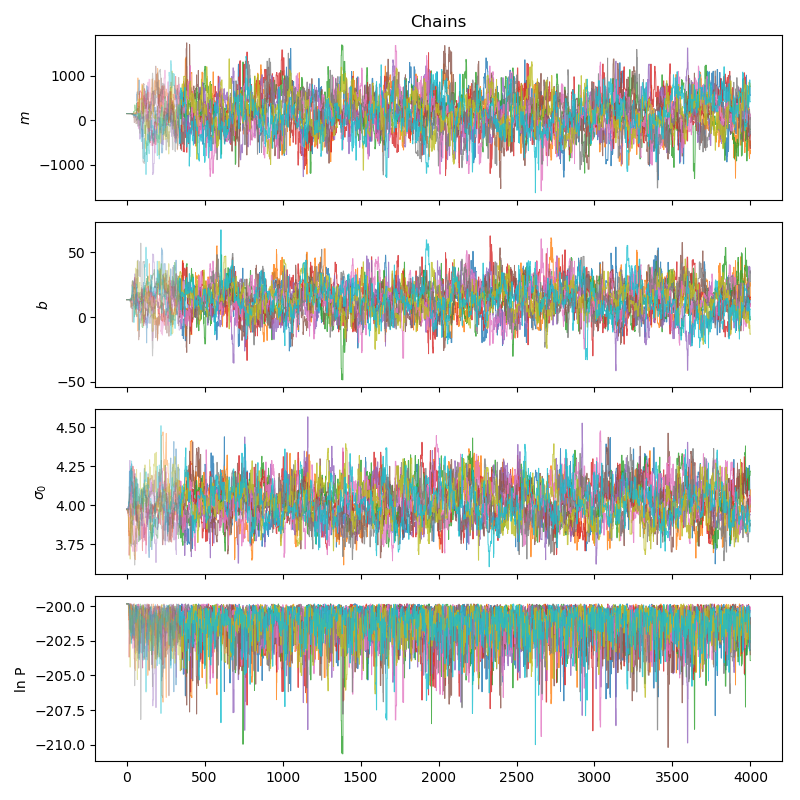

In [616]:
plotChains(sampler, int(10*tau[0]), paramsNames, nplot=10)
plt.tight_layout()

<IPython.core.display.Javascript object>


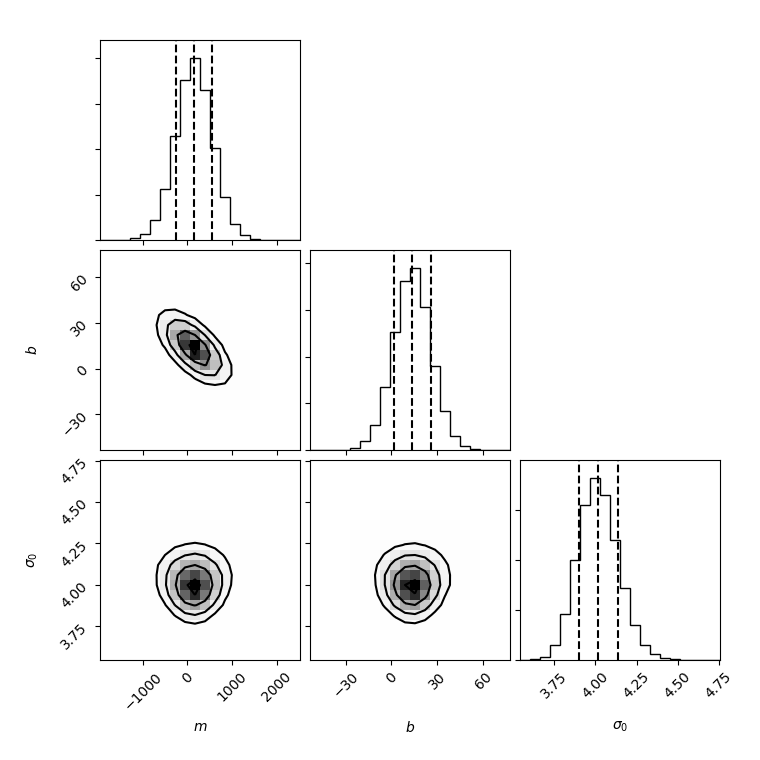

In [617]:
makeCorner(sampler, int(10*tau[0]), paramsNames)

In [618]:
samples = sampler.get_chain(discard = int(10*tau[0]), flat=True)
Fmcmc_low, Fmcmc_med, Fmcmc_high = np.percentile(samples[:,0], (15.87, 50, 84.13))
print('The best-fit slope is: {:.4f} +/- {:.4f}'.format(Fmcmc_med, (Fmcmc_high - Fmcmc_low)/2.))

The best-fit slope is: 147.0257 +/- 406.8619


### Test the mixture model likelihood

For the mixture model, the flexibility of the "background" which is simply a gaussian with arbitrary mean and arbitrarily large variance, it is "easy" to describe the data with all observations belonging to the background. This means initializing the walkers for MCMC integration requires a lot of care. 

As shown below, for observations with (highly likely) outliers, maximum-likelihood does not provide a reasonable estimate of the model parameters. We have found that for poorly initialized systems the walkers can easily be stuck in local maxima with very wide valleys separating the global maximum in the posterior. 

We have further found that it is possible to initiate the walkers near the global maximum, in which case the model converges fairly quickly, *BUT identifying this maximum is very difficult*. To try and do this in a general and automated fashion, we will initialize walkers over a wide range of posterior values, and then start a second run of walkers near the maximum posterior estimates.

In [619]:
grid_pos = list(np.reshape(np.mgrid[-250:251:125, -50:51:50, -5.2:-1.1:2, -5:6:5, -100:101:100].T, (405,5)))

grid_walkers = 405
grid_dim = 5
grid_sampler = emcee.EnsembleSampler(grid_walkers, grid_dim, mixture_lnprob, 
                                     args=(x, y, yerr))
grid_samples = 2500
grid_sampler.run_mcmc(grid_pos, grid_samples, progress=True)

idx1, idx2 = np.unravel_index(np.argmax(grid_sampler.lnprobability), np.shape(grid_sampler.lnprobability))

emcee_guess = grid_sampler.get_chain()[idx1,idx2,:]
pos = [emcee_guess + 1e-3*np.random.randn(grid_dim) for i in range(nwalkers)]

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
100%|██████████| 2500/2500 [00:45<00:00, 54.61it/s]


<IPython.core.display.Javascript object>


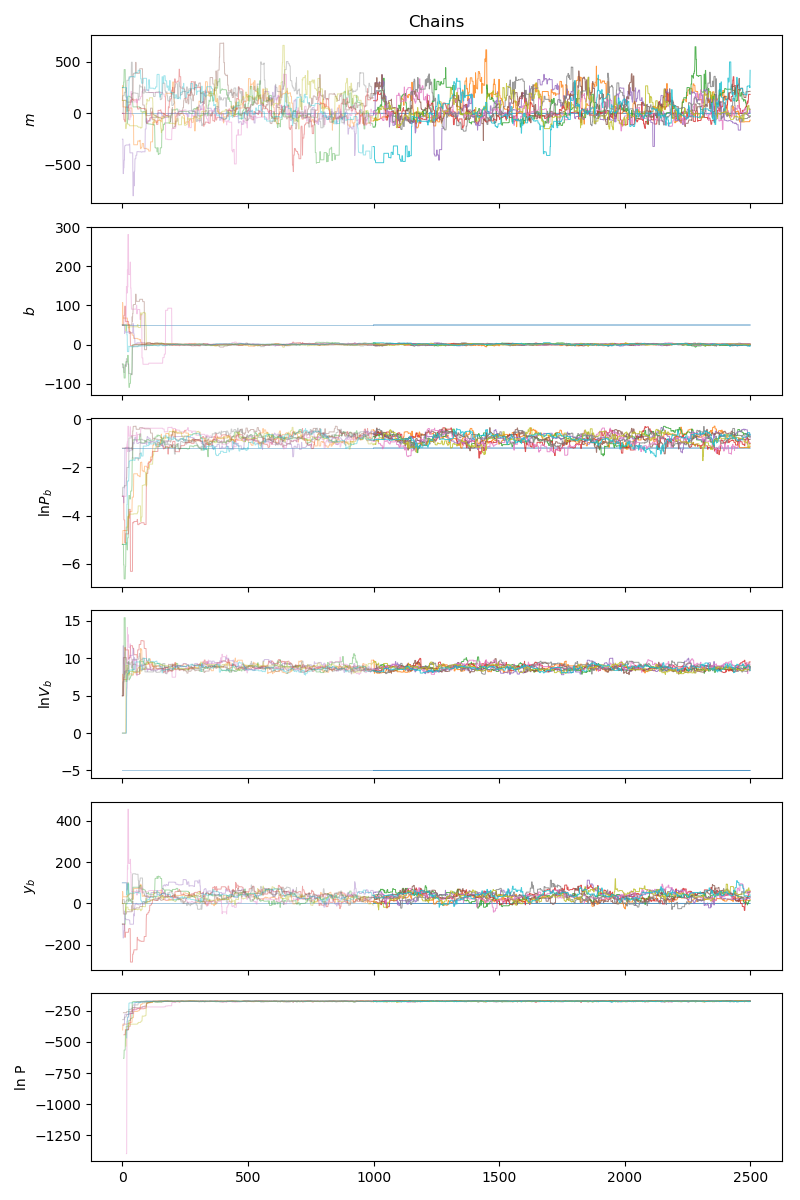

In [620]:
plotChains(grid_sampler, 1000, mixture_paramsNames, nplot=10)
plt.tight_layout()

In [621]:
# set up the sampler
mix_sampler = emcee.EnsembleSampler(nwalkers, grid_dim, mixture_lnprob, 
                                args=(x, y, yerr))

max_samples = 25000

index = 0
autocorr = np.zeros(max_samples)
old_tau = np.inf
check_tau = 250
for sample in mix_sampler.sample(pos, iterations=max_samples, progress=True):
    if (mix_sampler.iteration % 250) and (mix_sampler.iteration < 5000):
        continue
    elif (mix_sampler.iteration % 1000) and (5000 <= mix_sampler.iteration < 15000):
        continue
    elif (mix_sampler.iteration % 2500) and (15000 <= mix_sampler.iteration):
        continue
    mix_tau = mix_sampler.get_autocorr_time(tol=0)
    autocorr[mix_sampler.iteration-1] = np.mean(mix_tau)
    index += 1

    # Check convergence
    converged = np.all(mix_tau * 100 < mix_sampler.iteration)
    converged &= np.all(np.abs(old_tau - mix_tau) / mix_tau < 0.01)
    if converged:
        break
    old_tau = mix_tau

 48%|████▊     | 12000/25000 [02:32<02:45, 78.52it/s]


In [622]:
mix_tau

array([73.51562085, 67.81369495, 61.14120871, 59.58472221, 59.87251551])

<IPython.core.display.Javascript object>


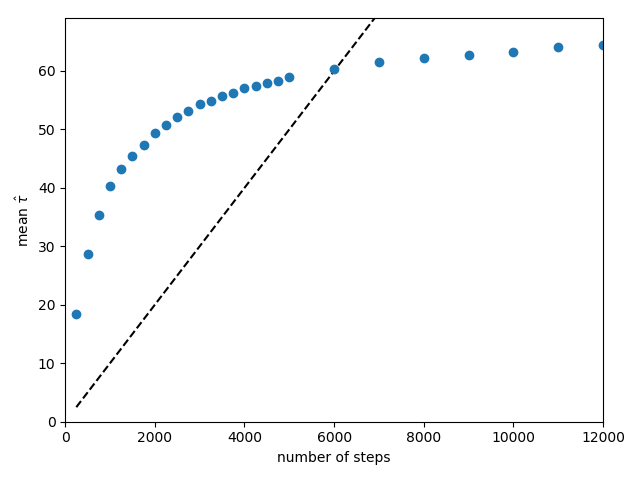

In [623]:
n = np.where(autocorr > 0)[0]
mean_tau = autocorr[np.where(autocorr > 0)]
plt.figure()
plt.plot(n, n / 100.0, "--k")
plt.plot(n, mean_tau, 'o')
plt.xlim(0, n.max())
plt.ylim(0, mean_tau.max() + 0.1*(mean_tau.max() - mean_tau.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$")
plt.tight_layout()

<IPython.core.display.Javascript object>


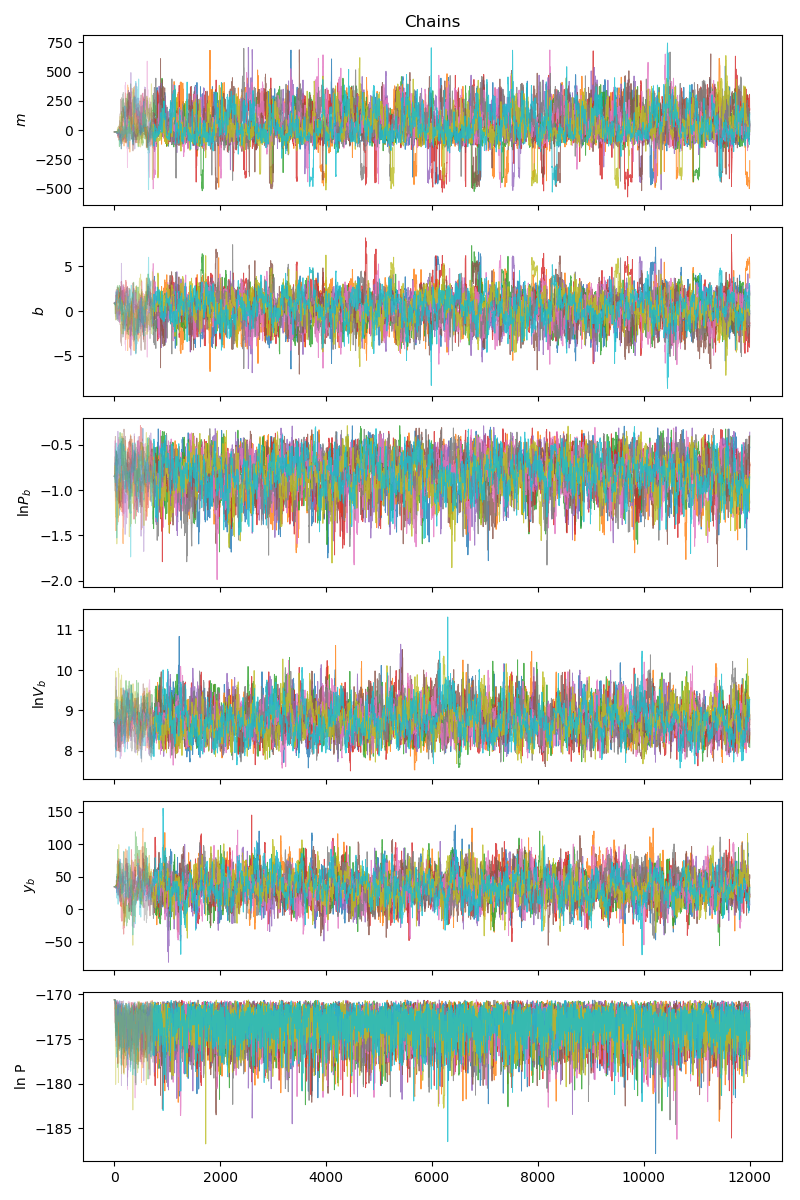

In [624]:
plotChains(mix_sampler, int(10*mix_tau[0]), mixture_paramsNames, nplot=10)
plt.tight_layout()

<IPython.core.display.Javascript object>


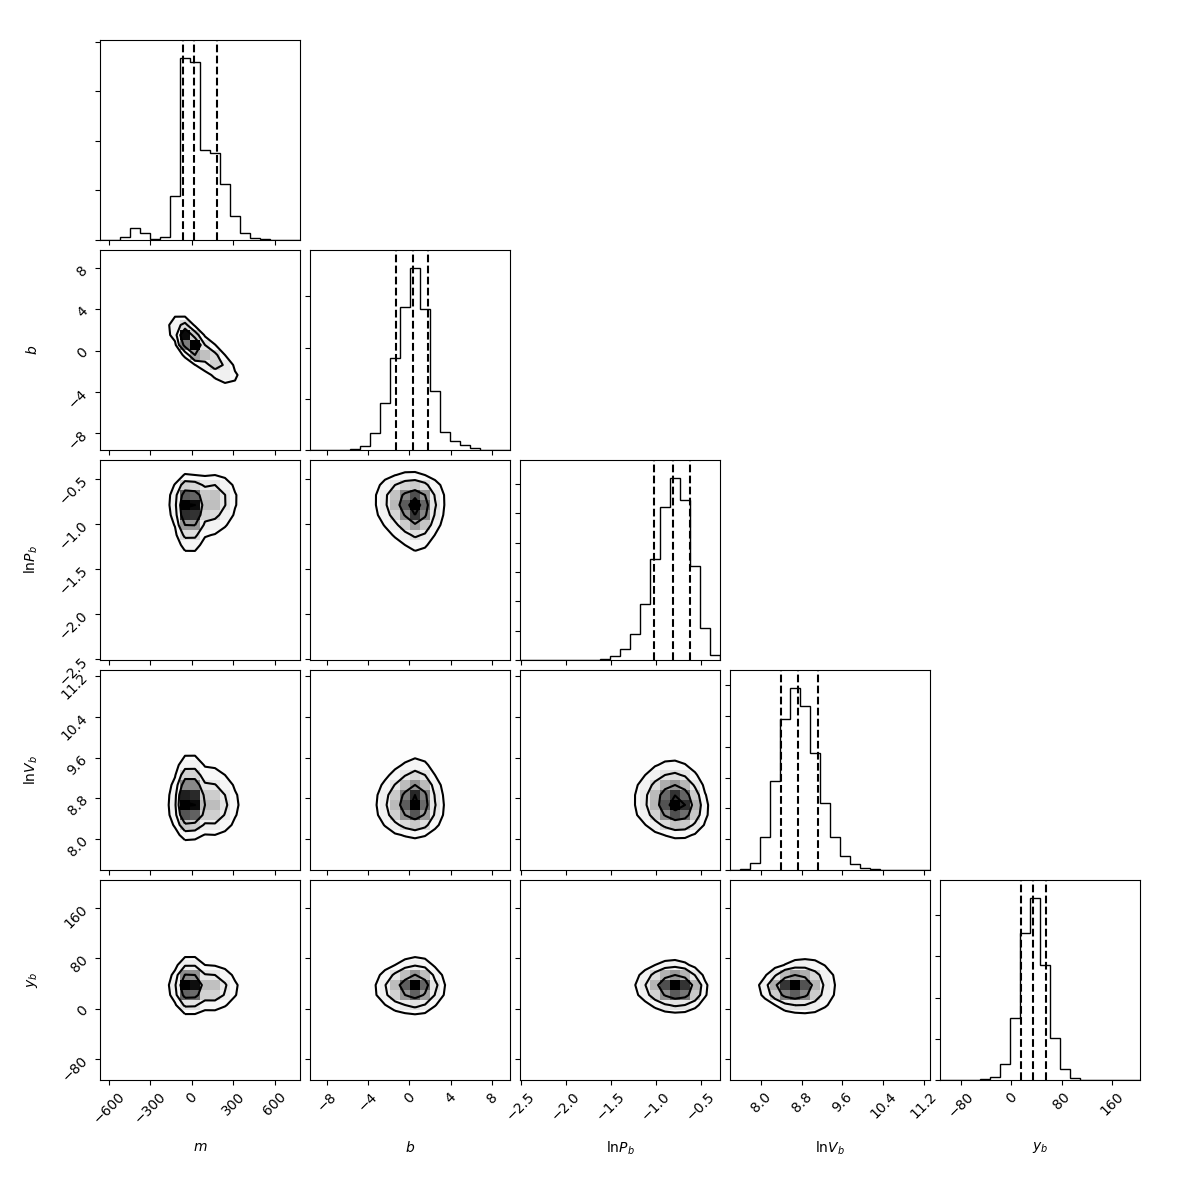

In [625]:
makeCorner(mix_sampler, int(10*mix_tau[0]), mixture_paramsNames)

In [626]:
samples = mix_sampler.get_chain(discard = int(10*mix_tau[0]), flat=True)
Fmcmc_low, Fmcmc_med, Fmcmc_high = np.percentile(samples[:,0], (15.87, 50, 84.13))
print('The best-fit slope is: {:.4f} +/- {:.4f}'.format(Fmcmc_med, (Fmcmc_high - Fmcmc_low)/2.))

The best-fit slope is: 18.9073 +/- 123.8976


<IPython.core.display.Javascript object>


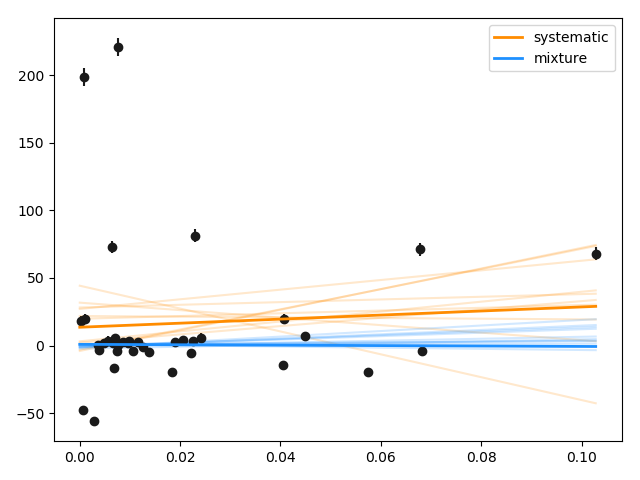

In [627]:
idx1, idx2 = np.unravel_index(np.argmax(sampler.lnprobability), np.shape(sampler.lnprobability))
m_sys, b_sys = sampler.get_chain()[idx1,idx2,:2]
idx1, idx2 = np.unravel_index(np.argmax(mix_sampler.lnprobability), np.shape(mix_sampler.lnprobability))
m_mix, b_mix = mix_sampler.get_chain()[idx1,idx2,:2]


fig, ax = plt.subplots()
ax.errorbar(x, y, yerr, fmt='o', color='0.1')
# plot systematic results
ax.plot([0,x.max()], [b_sys, b_sys+m_sys*x.max()], 
        'DarkOrange', label='systematic', lw=2, zorder=10)
sys_samples = sampler.get_chain(discard=int(10*tau[0]), flat=True)
rand_sys = np.random.choice(range(np.shape(sys_samples)[0]), 10, replace=False)
for samp in rand_sys:
    m_sys_samp, b_sys_samp = sys_samples[samp,:2]
    ax.plot([0,x.max()], 
            [b_sys_samp, b_sys_samp+m_sys_samp*x.max()], 
            'DarkOrange', alpha=0.2)

# plot mixture results
ax.plot([0,x.max()], [b_mix, b_mix+m_mix*x.max()], 
        'DodgerBlue', label='mixture', lw=2, zorder=10)

mix_samples = mix_sampler.get_chain(discard=int(10*mix_tau[0]), flat=True)
rand_mix = np.random.choice(range(np.shape(mix_samples)[0]), 10, replace=False)
for samp in rand_mix:
    m_mix_samp, b_mix_samp = mix_samples[samp,:2]
    ax.plot([0,x.max()], 
            [b_mix_samp, b_mix_samp+m_mix_samp*x.max()], 
            'DodgerBlue', alpha=0.2)
ax.legend()
fig.tight_layout()


## Script up parallel solution

Now that we have a method to identify the best fit slope, we would like to take advantage of the fact that this problem can be parallelized by fitting each epoch individually. 

#### Define MCMC for systematic term likelihood for a single source

In [460]:
def pool_sys_process(tb, i):
    subtb = tb[tb['index']==i]
    x = subtb['x'].values
    y = subtb['y'].values
    yerr = subtb['ey'].values
        
    result = op.minimize(nll, [0, 0, 2], 
                         method='Powell', args=(x, y, yerr))
    ml_guess = result["x"]

    if ml_guess[-1] < -49:
        ml_guess[-1] = -35
    ndim = len(ml_guess)
    nwalkers = 250
    
    pos = [ml_guess + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

    # set up the sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, systematic_lnprob, 
                                    args=(x, y, yerr))

    max_samples = 100000

    index = 0
    autocorr = np.empty(max_samples)
    old_tau = np.inf
    check_tau = 250
    for sample in sampler.sample(pos, iterations=max_samples, progress=False):
        if sampler.iteration % check_tau:
            continue
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau  
    
    samples = sampler.get_chain(discard=int(5*tau[0]), flat=True)
    
    Fmcmc_low, Fmcmc_med, Fmcmc_high = np.percentile(samples[:,0], (15.87, 50, 84.13))
    amcmc_low, amcmc_med, amcmc_high = np.percentile(samples[:,1], (15.87, 50, 84.13))
    # lnf_low, lnf_med, lnf_high = np.percentile(samples.T[2], (15.87, 50, 84.13))
    result = np.array([i, # position argument
                       Fmcmc_med, (Fmcmc_high - Fmcmc_low)/2.,
                       amcmc_med, (amcmc_high - amcmc_low)/2.])
    return result

#### Define MCMC for mixture model likelihood for a single source

In [597]:
def pool_mix_process(tb, i):
    print(i)
    subtb = tb[tb['index']==i]
    x = subtb['x'].values
    y = subtb['y'].values
    yerr = subtb['ey'].values

    nwalkers = 250
    ndim = 5
    
    # posterior is highly multi-modal, run a "burn-in" ensemble first
    grid_pos = list(np.reshape(np.mgrid[-250:251:125, -50:51:50, -5.2:-1.1:2, -5:6:5, -100:101:100].T, (405,5)))
    grid_walkers = 405
    grid_sampler = emcee.EnsembleSampler(grid_walkers, ndim, mixture_lnprob, 
                                         args=(x, y, yerr))
    grid_samples = 2500
    grid_sampler.run_mcmc(grid_pos, grid_samples, progress=False)

    idx1, idx2 = np.unravel_index(np.argmax(grid_sampler.lnprobability), np.shape(grid_sampler.lnprobability))

    emcee_guess = grid_sampler.get_chain()[idx1,idx2,:]
    pos = [emcee_guess + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
    
    mix_sampler = emcee.EnsembleSampler(nwalkers, ndim, mixture_lnprob, 
                                args=(x, y, yerr))

    max_samples = 25000

    autocorr = np.empty(max_samples)
    old_tau = np.inf
    for sample in mix_sampler.sample(pos, iterations=max_samples, progress=False):
        if (mix_sampler.iteration % 250) and (mix_sampler.iteration < 5000):
            continue
        elif (mix_sampler.iteration % 1000) and (5000 <= mix_sampler.iteration < 15000):
            continue
        elif (mix_sampler.iteration % 2500) and (15000 <= mix_sampler.iteration):
            continue
        mix_tau = mix_sampler.get_autocorr_time(tol=0)
        autocorr[mix_sampler.iteration-1] = np.mean(mix_tau)

        # Check convergence
        converged = np.all(mix_tau * 100 < mix_sampler.iteration)
        converged &= np.all(np.abs(old_tau - mix_tau) / mix_tau < 0.01)
        if converged:
            break
        old_tau = mix_tau
    
    mix_samples = mix_sampler.get_chain(discard=int(5*tau[0]), flat=True)
    
    Fmcmc_low, Fmcmc_med, Fmcmc_high = np.percentile(mix_samples[:,0], (15.87, 50, 84.13))
    amcmc_low, amcmc_med, amcmc_high = np.percentile(mix_samples[:,1], (15.87, 50, 84.13))
    result = np.array([i, # position argument
                       Fmcmc_med, (Fmcmc_high - Fmcmc_low)/2.,
                       amcmc_med, (amcmc_high - amcmc_low)/2.])
    return result

In [598]:
pool = Pool(processes=4)
tstart = time.time()
results = [pool.apply_async(pool_mix_process, args=(tb2, i,)) for i in range(4)]
output = [p.get() for p in results]
tend = time.time()

print("Pool map took {:.4f} sec".format(tend-tstart))

0
1
2


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


3


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
 90%|█████████ | 22500/25000 [06:26<00:42, 58.27it/s]


Pool map took 450.9754 sec


In [601]:
output

[array([   0.        , -135.32920642,   62.96600296,    2.80687566,
           1.55688658]),
 array([ 1.00000000e+00, -2.26578183e+03,  1.09974331e+03,  1.41724513e+02,
         5.54310802e+00]),
 array([ 2.        ,  4.04412279, 83.4419023 , -0.16813332,  1.7397543 ]),
 array([  3.        ,  -9.8850982 ,  73.00987746, -11.69389273,
          2.09714441])]

### Test results 

There are two potential approaches. The first is to apply an asynchronous loop of all sources over multiple processors, the second is to queue up N obs at a time, where N = number of CPUs. 

Both are tested below, and it appears clear that the asynchronous method greatly outperforms the quantized operation of N measurements at a time.

In [79]:
pool = Pool(processes=4)
tstart = time.time()
results = [pool.apply_async(pool_sys_process, args=(tb2, i,)) for i in range(17)]
output = [p.get() for p in results]
tend = time.time()

print("Pool map took {:.4f} sec".format(tend-tstart))

0
1
2
3


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


4


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


5
6
7
8
9
10
11
12
13
14
15
16
Pool map took 400.6010 sec


In [77]:
def single_process(tb, i, output):
    print (i)
    subtb = tb[tb['index']==i]
    x = subtb['x'].values
    y = subtb['y'].values
    yerr = subtb['ey'].values
        
    # two parameters (np.log(f_true) = 0)
    result = op.minimize(nll, [0, 0, 2], 
                         method='Powell', args=(x, y, yerr))
    ml_guess = result["x"]

    if ml_guess[-1] < -49:
        ml_guess[-1] = -35
    ndim = len(ml_guess)
    nwalkers = 250
    
    # two parameters
    pos = [ml_guess + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

    # set up the sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, systematic_lnprob, 
                                    args=(x, y, yerr))

    max_samples = 100000

    index = 0
    autocorr = np.empty(max_samples)
    old_tau = np.inf
    check_tau = 250
    for sample in sampler.sample(pos, iterations=max_samples, progress=False):
        if sampler.iteration % check_tau:
            continue
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau  
    
    samples = sampler.get_chain(discard=int(5*tau[0]), flat=True)
    
    Fmcmc_low, Fmcmc_med, Fmcmc_high = np.percentile(samples[:,0], (15.87, 50, 84.13))
    amcmc_low, amcmc_med, amcmc_high = np.percentile(samples[:,1], (15.87, 50, 84.13))
    # lnf_low, lnf_med, lnf_high = np.percentile(samples.T[2], (15.87, 50, 84.13))
    result = np.array([i, # position argument
                       Fmcmc_med, (Fmcmc_high - Fmcmc_low)/2.,
                       amcmc_med, (amcmc_high - amcmc_low)/2.])
    output.put(result)

In [80]:
tstart = time.time()
n2=17
ncpu = 4
nruns = math.ceil(n2/ncpu)
results = []
for j in range(math.ceil(n2/ncpu)):
#for j in range(2):
    if j==nruns-1:
        irange = np.arange(j*ncpu, n2)
    else:
        irange = np.arange(j*ncpu, (j+1)*ncpu)
        
    output = Queue()
    processes = [Process(target=single_process, args=(tb2, i, output)) for i in irange]
    # Run processes
    for p in processes:
        p.start()

    # Exit the completed processes
    for p in processes:
        p.join()
    
    temp = [output.get() for p in processes]
    results.append(temp)
    
    output.close()
tend = time.time()
print("Queue took {:.4f} sec".format(tend-tstart))

0
1
2
3


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


4
5
6
7


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encoun

8
9
10
11


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encoun

12
13
14
15


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


16


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


Queue took 522.1754 sec


Based on the above (limited) test, it appears that the async method is much faster then throwing everything into a queue. We will proceed with that moving forward.

In [545]:
#define funtion to make corner plot
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84], truths=[]):
    samples = sampler.get_chain(discard=nburn, flat=True)
    if len(truths) > 0:
        f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, 
                          truths=truths, plot_datapoints=False)
    else:
        f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, 
                          plot_datapoints=False )
    
#define function to plot walker chains  
def plotChains(sampler, nburn, paramsNames, nplot=nwalkers):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams+1,1, figsize = (8,2*(Nparams+1)), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = np.arange(sampler.get_chain().shape[0])

    selected_walkers = np.random.choice(range(sampler.get_chain().shape[1]), nplot, replace=False)
    for i,p in enumerate(paramsNames):
        for w in selected_walkers:
            burn = ax[i].plot(xplot[:nburn], sampler.get_chain()[:nburn,w,i], 
                              alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.get_chain(discard=nburn)[:,w,i], 
                       color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            if i==Nparams-1:
                ax[i+1].plot(xplot[:nburn], sampler.get_log_prob()[:nburn,w], 
                             color=burn[0].get_color(), alpha = 0.4, lw = 0.7, zorder = 1)
                ax[i+1].plot(xplot[nburn:], sampler.get_log_prob(discard=nburn)[:,w], 
                             color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
                ax[i+1].set_ylabel('ln P')
            
    return ax

paramsNames=['$m$', '$b$', '$\sigma_0$']
mixture_paramsNames=['$m$', '$b$', '$\ln P_b$', '$\ln V_b$', '$y_b$']